In [1]:
using Surrogates
using Plots
using Statistics
using Random
using DataFrames
using Distances
default()

In [2]:
function splitdf(df, pct)
           @assert 0 <= pct <= 1
           ids = collect(axes(df, 1))
           shuffle!(ids)
           sel = ids .<= nrow(df) .* pct
           return view(df, sel, :), view(df, .!sel, :)
       end

splitdf (generic function with 1 method)

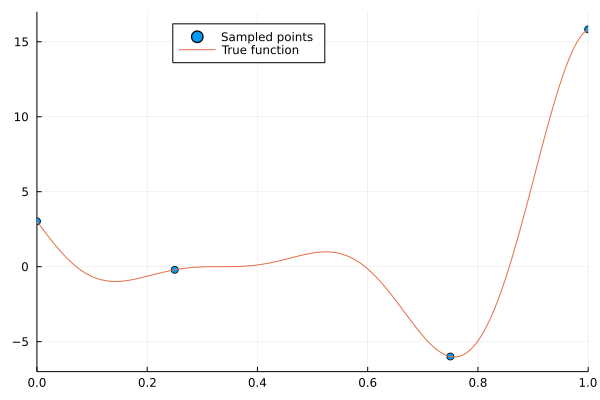

In [59]:
f(x) = (6 * x - 2)^2 * sin(12 * x - 4)

n_samples = 5
lower_bound = 0.0
upper_bound = 1.0

xs = lower_bound:0.001:upper_bound

x = sample(n_samples, lower_bound, upper_bound, SobolSample())
append!(x, lower_bound)
append!(x, upper_bound)
original_x = copy(x)
y = f.(x)
original_y = copy(y)

scatter(original_x, original_y, label="Sampled points", xlims=(lower_bound, upper_bound), ylims=(-7, 17))
plot!(xs, f.(xs), label="True function", legend=:top)

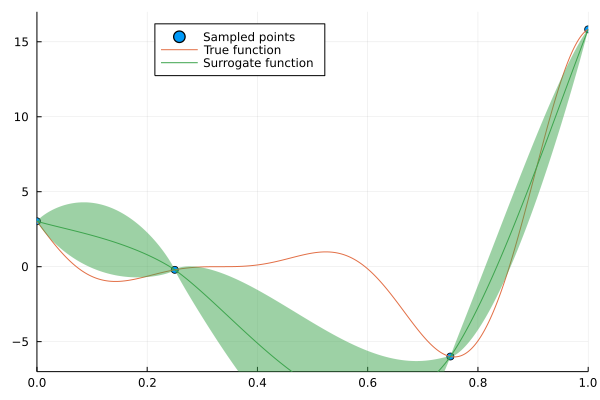

In [15]:
kriging_surrogate = Kriging(original_x, original_y, lower_bound, upper_bound, p=1.9);

plot(original_x, original_y, seriestype=:scatter, label="Sampled points", xlims=(lower_bound, upper_bound), ylims=(-7, 17), legend=:top)
plot!(xs, f.(xs), label="True function", legend=:top)
plot!(xs, kriging_surrogate.(xs), label="Surrogate function", ribbon=p->std_error_at_point(kriging_surrogate, p), legend=:top)

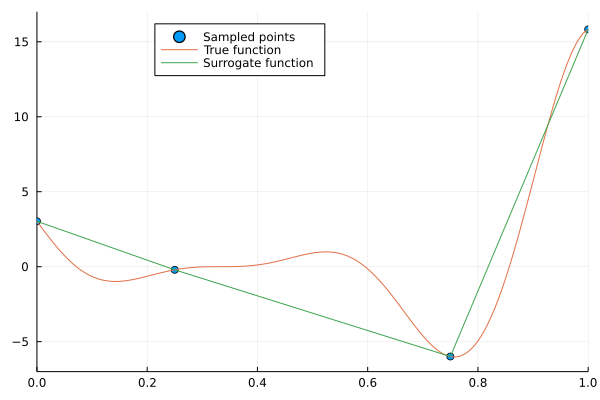

In [16]:
my_radial_basis = RadialBasis(original_x, original_y, lower_bound, upper_bound)
plot(original_x, original_y, seriestype=:scatter, label="Sampled points", xlims=(lower_bound, upper_bound), ylims=(-7, 17), legend=:top)
plot!(xs, f.(xs), label="True function", legend=:top)
plot!(xs, my_radial_basis.(xs), label="Surrogate function", legend=:top)

In [91]:
# Implementing diversity
function calculate_variance(x, models)
    predictions = []
        for model in models
            prediction = model(x)
            append!(predictions, prediction)
        end
    return var(predictions, corrected=false)
end

function diversity_metric(prev_x, new_x, models, lambda = 0.5)
    min_dist = Inf
    variance = calculate_variance(new_x, models)
    for point in prev_x
        new_dist = euclidean(point, new_x)
        if new_dist < min_dist
            min_dist = new_dist
        end
    end
    return (1 - lambda) * variance + lambda * min_dist
end

diversity_metric (generic function with 2 methods)

In [23]:
prev_points = copy(original_x)
y = copy(original_y)
sample_space = collect(xs)
for i in 1:5
    kriging_surrogate = Kriging(prev_points, y, lower_bound, upper_bound, p=1.9)
    my_radial_basis = RadialBasis(prev_points, y, lower_bound, upper_bound)
    x = []
    for i in 1:n_samples
        max_score = 0
        max_index = -1
        for j in 1:length(sample_space)
            score = diversity_metric(prev_points, sample_space[j], [my_radial_basis, kriging_surrogate], 0)
            if score > max_score
                max_score = score
                max_index = j
            end
        end
        append!(x, sample_space[max_index])
        deleteat!(sample_space, max_index)
    end
    prev_points = vcat(prev_points, x)
    y = f.(prev_points)
end

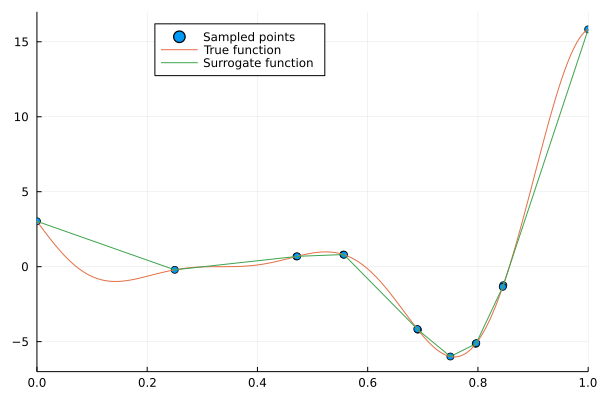

In [24]:
my_radial_basis = RadialBasis(prev_points, y, lower_bound, upper_bound)
plot(prev_points, y, seriestype=:scatter, label="Sampled points", xlims=(lower_bound, upper_bound), ylims=(-7, 17), legend=:top)
plot!(xs, f.(xs), label="True function", legend=:top)
plot!(xs, my_radial_basis.(xs), label="Surrogate function", legend=:top)

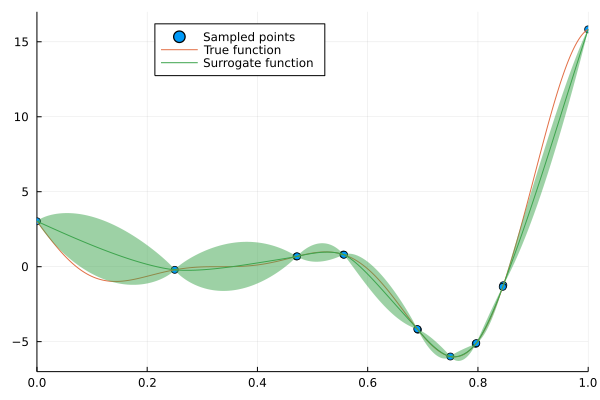

In [25]:
kriging_surrogate = Kriging(prev_points, y, lower_bound, upper_bound, p=1.9)
plot(prev_points, y, seriestype=:scatter, label="Sampled points", xlims=(lower_bound, upper_bound), ylims=(-7, 17), legend=:top)
plot!(xs, f.(xs), label="True function", legend=:top)
plot!(xs, kriging_surrogate.(xs), label="Surrogate function", ribbon=p->std_error_at_point(kriging_surrogate, p), legend=:top)

In [60]:
prev_points = copy(original_x)
y = copy(original_y)
sample_space = collect(xs)
for i in 1:10
    kriging_surrogate = Kriging(prev_points, y, lower_bound, upper_bound, p=1.9)
    my_radial_basis = RadialBasis(prev_points, y, lower_bound, upper_bound)
    x = []
    for i in 1:n_samples
        max_score = 0
        max_index = -1
        for j in 1:length(sample_space)
            score = diversity_metric(prev_points, sample_space[j], [my_radial_basis, kriging_surrogate], 0.98)
            if score > max_score
                max_score = score
                max_index = j
            end
        end
        append!(x, sample_space[max_index])
        deleteat!(sample_space, max_index)
    end
    prev_points = vcat(prev_points, x)
    y = f.(prev_points)
end

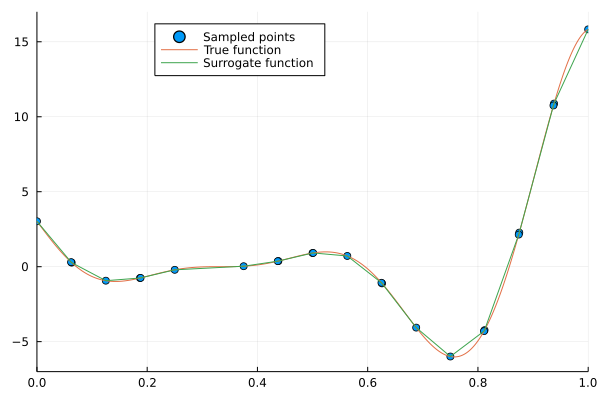

In [30]:
my_radial_basis = RadialBasis(prev_points, y, lower_bound, upper_bound)
plot(prev_points, y, seriestype=:scatter, label="Sampled points", xlims=(lower_bound, upper_bound), ylims=(-7, 17), legend=:top)
plot!(xs, f.(xs), label="True function", legend=:top)
plot!(xs, my_radial_basis.(xs), label="Surrogate function", legend=:top)

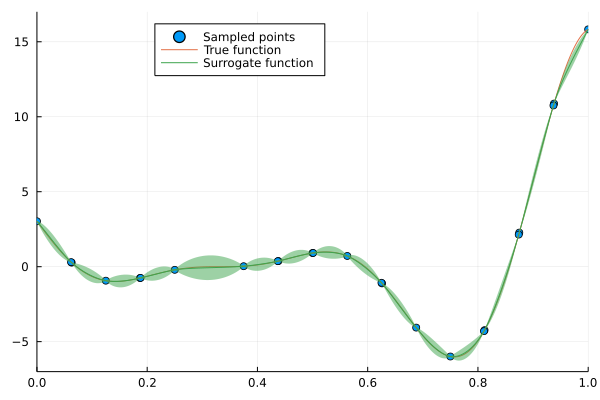

In [31]:
kriging_surrogate = Kriging(prev_points, y, lower_bound, upper_bound, p=1.9)
plot(prev_points, y, seriestype=:scatter, label="Sampled points", xlims=(lower_bound, upper_bound), ylims=(-7, 17), legend=:top)
plot!(xs, f.(xs), label="True function", legend=:top)
plot!(xs, kriging_surrogate.(xs), label="Surrogate function", ribbon=p->std_error_at_point(kriging_surrogate, p), legend=:top)

In [61]:
size(prev_points)

(24,)

In [246]:
function booth(x)
    x1=x[1]
    x2=x[2]
    term1 = (x1 + 2*x2 - 7)^2;
    term2 = (2*x1 + x2 - 5)^2;
    y = term1 + term2;
end

booth (generic function with 1 method)

In [247]:
n_samples = 20
lower_bound = [-5.0, 0.0]
upper_bound = [10.0, 15.0]

xys = sample(n_samples, lower_bound, upper_bound, SobolSample())
push!(xys, (-5, 0))
push!(xys, (-5, 15))
push!(xys, (10, 0))
push!(xys, (10, 15))
zs = booth.(xys);

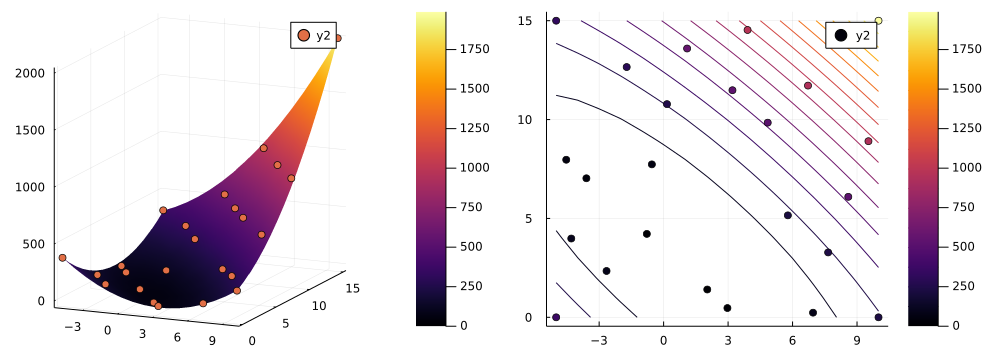

In [251]:
xs = [xy[1] for xy in xys]
ys = [xy[2] for xy in xys]
x = -5.0:10.0
y = 0.0:15.0
p1 = surface(x, y, (x, y) -> booth([x y])) # hide
scatter!(xs, ys, zs)
p2 = contour(x, y, (x, y) -> booth([x y]))
scatter!(xs, ys, marker_z=zs)
display(plot!(p1, p2, size=(1000,350), reuse=false))

In [238]:
radial_basis = RadialBasis(xys, zs,  lower_bound, upper_bound)

(::RadialBasis{Surrogates.var"#1#2", Int64, Vector{Tuple{Float64, Float64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, LinearAlgebra.Transpose{Float64, Vector{Float64}}, Float64, Bool}) (generic function with 1 method)

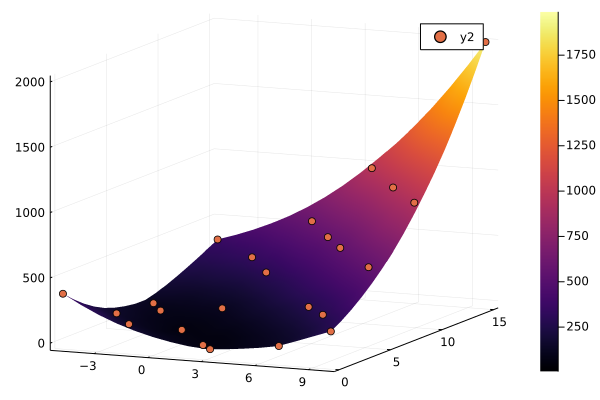

In [239]:
x = -5.0:10.0
y = 0.0:15.0
p1 = surface(x, y, (x, y) -> radial_basis([x y])) # hide
scatter!(xs, ys, zs)

In [283]:
total_samples = 1000
prev_points = copy(xys)
z = copy(zs)
sample_space = sample(total_samples, lower_bound, upper_bound, SobolSample())
for i in 1:10
    kriging_surrogate = Kriging(prev_points, z, lower_bound, upper_bound, p=[1.9, 1.9])
    my_radial_basis = RadialBasis(prev_points, z, lower_bound, upper_bound)
    x = []
    max_score = 0
    max_index = -1
    for j in 1:length(sample_space)
        score = diversity_metric(prev_points, sample_space[j], [my_radial_basis, kriging_surrogate], 0)
        if score > max_score
            max_score = score
            max_index = j
        end
    end
    append!(x, sample_space[[max_index]])
    deleteat!(sample_space, max_index)
    prev_points = vcat(prev_points, x)
    z = booth.(prev_points)
end

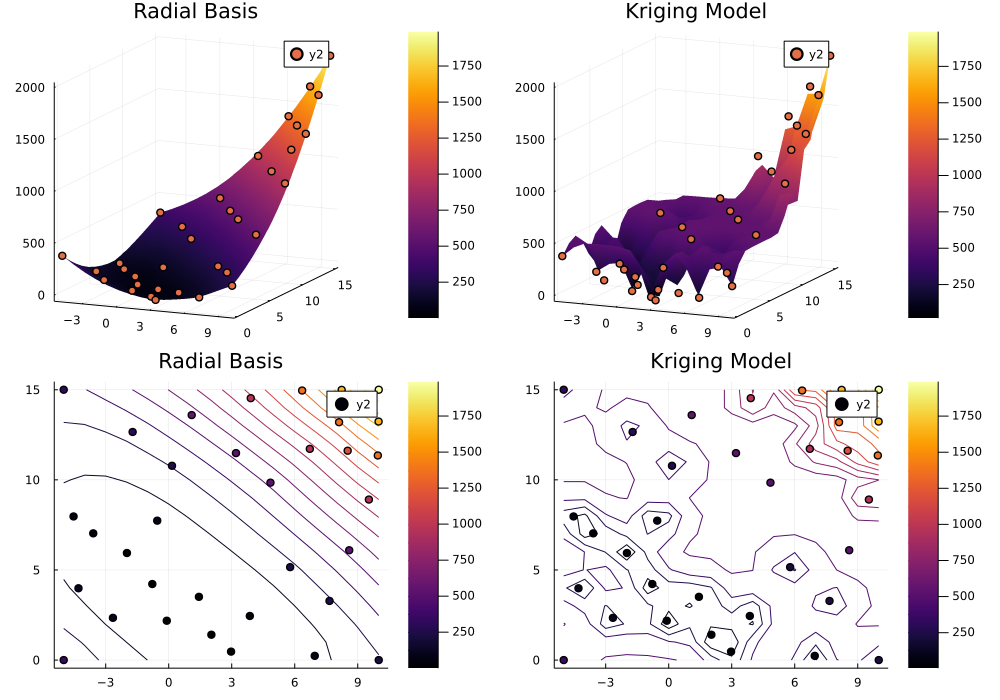

In [284]:
new_xs = [xy[1] for xy in prev_points]
new_ys = [xy[2] for xy in prev_points]
x = -5.0:10.0
y = 0.0:15.0
my_radial_basis = RadialBasis(prev_points, z, lower_bound, upper_bound)
my_kriging_model = Kriging(prev_points, z, lower_bound, upper_bound, p=[1.9, 1.9])
radial_zs = my_radial_basis.(prev_points)
p1 = surface(x, y, (x, y) -> my_radial_basis([x y]), title="Radial Basis")
scatter!(new_xs, new_ys, radial_zs)
kriging_zs = my_kriging_model.(prev_points)
p2 = surface(x, y, (x, y) -> my_kriging_model([x y]), title="Kriging Model")
scatter!(new_xs, new_ys, kriging_zs)
p3 = contour(x, y, (x, y) -> my_radial_basis([x y]), title="Radial Basis")
scatter!(new_xs, new_ys, marker_z=radial_zs)
p4 = contour(x, y, (x, y) -> my_kriging_model([x y]), title="Kriging Model")
scatter!(new_xs, new_ys, marker_z=kriging_zs)
display(plot!(p1, p2, p3, p4, size=(1000,700), reuse=false))

In [264]:
a, b = splitdf(DataFrame(xys), 0.2)
a

,1,2
,Float64,Float64
1,7.65625,3.28125
2,4.84375,9.84375
3,8.59375,6.09375
4,10.0,0.0


In [279]:
c = Matrix(a)


7.65625

In [269]:
xys

24-element Vector{Tuple{Float64, Float64}}:
 (-3.59375, 7.03125)
 (3.90625, 14.53125)
 (7.65625, 3.28125)
 (0.15625, 10.78125)
 (2.03125, 1.40625)
 (9.53125, 8.90625)
 (5.78125, 5.15625)
 (-1.71875, 12.65625)
 (-2.65625, 2.34375)
 (4.84375, 9.84375)
 (8.59375, 6.09375)
 (1.09375, 13.59375)
 (-0.78125, 4.21875)
 (6.71875, 11.71875)
 (2.96875, 0.46875)
 (-4.53125, 7.96875)
 (-4.296875, 3.984375)
 (3.203125, 11.484375)
 (6.953125, 0.234375)
 (-0.546875, 7.734375)
 (-5.0, 0.0)
 (-5.0, 15.0)
 (10.0, 0.0)
 (10.0, 15.0)

In [280]:
total_samples = 1000
prev_points = copy(xys)
z = copy(zs)
sample_space = sample(total_samples, lower_bound, upper_bound, SobolSample())
for i in 1:10
    kriging_surrogate = Kriging(prev_points, z, lower_bound, upper_bound, p=[1.9, 1.9])
    my_radial_basis = RadialBasis(prev_points, z, lower_bound, upper_bound)
    x = []
    max_score = 0
    max_index = -1
    for j in 1:length(sample_space)
        score = diversity_metric(prev_points, sample_space[j], [my_radial_basis, kriging_surrogate], 1)
        if score > max_score
            max_score = score
            max_index = j
        end
    end
    append!(x, sample_space[[max_index]])
    deleteat!(sample_space, max_index)
    prev_points = vcat(prev_points, x)
    z = booth.(prev_points)
end

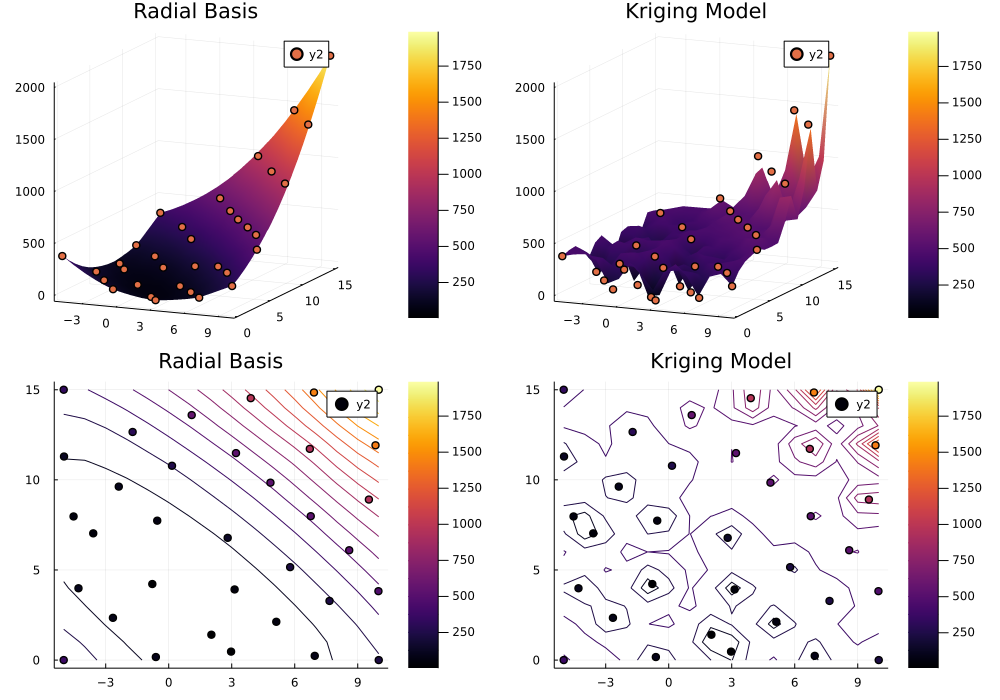

In [282]:
new_xs = [xy[1] for xy in prev_points]
new_ys = [xy[2] for xy in prev_points]
x = -5.0:10.0
y = 0.0:15.0
my_radial_basis = RadialBasis(prev_points, z, lower_bound, upper_bound)
my_kriging_model = Kriging(prev_points, z, lower_bound, upper_bound, p=[1.9, 1.9])
radial_zs = my_radial_basis.(prev_points)
p1 = surface(x, y, (x, y) -> my_radial_basis([x y]), title="Radial Basis")
scatter!(new_xs, new_ys, radial_zs)
kriging_zs = my_kriging_model.(prev_points)
p2 = surface(x, y, (x, y) -> my_kriging_model([x y]), title="Kriging Model")
scatter!(new_xs, new_ys, kriging_zs)
p3 = contour(x, y, (x, y) -> my_radial_basis([x y]), title="Radial Basis")
scatter!(new_xs, new_ys, marker_z=radial_zs)
p4 = contour(x, y, (x, y) -> my_kriging_model([x y]), title="Kriging Model")
scatter!(new_xs, new_ys, marker_z=kriging_zs)
display(plot!(p1, p2, p3, p4, size=(1000,700), reuse=false))